### In this example we shocase how to learn trees that trade-off between tests costs (feature costs) and accuracy. 

#### First we generate a toy dataset.

In [64]:
!pip install git+https://github.com/KohlerHECTOR/dpdt-py.git@v0.2.5

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/KohlerHECTOR/dpdt-py.git (to revision v0.2.5) to /tmp/pip-req-build-8n_lrh5k
  Running command git clone --filter=blob:none --quiet https://github.com/KohlerHECTOR/dpdt-py.git /tmp/pip-req-build-8n_lrh5k
  Resolved https://github.com/KohlerHECTOR/dpdt-py.git to commit deeec4a7b953b1fae4d6738d8ff4eb4da192e6de
  Preparing metadata (setup.py) ... done


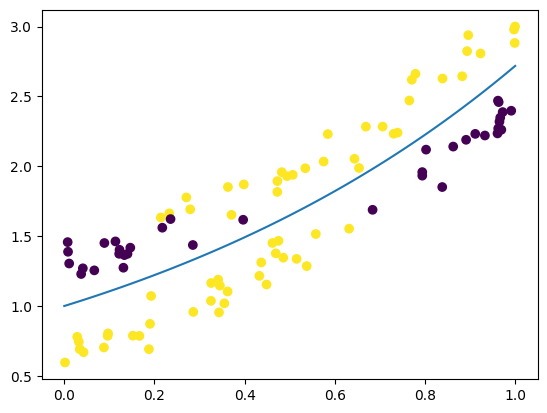

In [65]:
import numpy as np
import matplotlib.pyplot as plt

X1 = np.random.random(100)
X2 = np.exp(X1)
X2[:50] = X2[:50] + np.random.normal(loc=0.3, scale=0.1, size=50)
X2[50:] = X2[50:] + np.random.normal(loc=-0.3, scale=0.1, size=50)
X = np.hstack((X1[:, None], X2[:, None]))

half_x2 = np.median(X2)
y = [
    1
    if ((x2 <= np.exp(x1)) and x2 <= half_x2) or ((x2 > np.exp(x1)) and x2 > half_x2)
    else 0
    for x1, x2 in list(zip(X1, X2))
]

plt.scatter(X1, X2, c=y)
plt.plot(np.linspace(0, 1, 100), np.exp(np.linspace(0, 1, 100)))

#### We now augment the dataset with additional features namely $x_3 = x_2 - x_1$ and $x_4 = x_2 - \exp(x_1)$. Testing those features will be make more costly that classical axes-parallel tests. 

In [66]:
from sklearn.model_selection import train_test_split

X3 = X2 - X1
X4 = X2 - np.exp(X1)
X = np.hstack((X, X3[:, None], X4[:, None]))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

We can now instantiate and fit a DPDTree classifier

In [67]:
from dpdt import DPDTreeClassifier
from sklearn.tree import DecisionTreeClassifier

feature_costs = (1, 1, 2, 4)  # Costs for X1, X2, X3, X4

dpdt = DPDTreeClassifier(max_depth=3, random_state=42, cart_nodes_list=(3,))
dpdt.fit(X_train, y_train, feature_costs)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

Compute the tree traversal costs for the default sklearn classifier.

In [68]:
def avg_tree_cost(clf, X):
    node_indicator = clf.decision_path(X)
    leaf_id = clf.apply(X)
    costs_per_sample = []
    for sample_id in range(len(X)):
        cost_this_sample = 0
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
        ]

        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue
            else:
                cost_this_sample += feature_costs[clf.tree_.feature[node_id]]
        costs_per_sample.append(cost_this_sample)
    return np.mean(costs_per_sample)

### Let us now compute the cost accuracy pareto fronts.

In [69]:
from time import time

t = time()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
scores_clf, avg_cost_clf = np.zeros_like(ccp_alphas), np.zeros_like(ccp_alphas)
for c, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    scores_clf[c], avg_cost_clf[c] = clf.score(X_test, y_test), avg_tree_cost(
        clf, X_test
    )
time_pareto_front_clf = time() - t

In [70]:
t = time()
scores_dpdt, ld, costs_dpdt = dpdt.get_pareto_front(X_test, y_test)
time_pareto_front_dpdt = time() - t

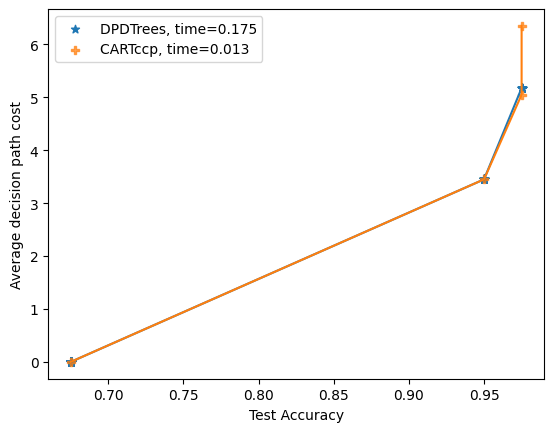

In [71]:
plt.scatter(
    scores_dpdt,
    costs_dpdt,
    label="DPDTrees, time={}".format(round(time_pareto_front_dpdt, 3)),
    marker="*",
)
plt.plot(scores_dpdt, costs_dpdt)
plt.scatter(
    scores_clf,
    avg_cost_clf,
    label="CARTccp, time={}".format(round(time_pareto_front_clf, 3)),
    marker="P",
    alpha=0.7,
)
plt.plot(scores_clf, avg_cost_clf)
plt.xlabel("Test Accuracy")
plt.ylabel("Average decision path cost")
plt.title("")
plt.legend()
plt.show()